In [ ]:
# ✅ Grad-CAM + Score-CAM + Bounding Box Overlay (CT 기반 통합 시각화)

import os
import re
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import torch.nn.functional as F
import cv2
import pandas as pd
import sys
sys.path.append("/home/iujeong/lung_cancer")
from glob import glob
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from ResNet18_CBAM_MGA.core.config import CFG
from ResNet18_CBAM_MGA.core.dataset import CTDataset, load_bbox_dict, extract_label
from ResNet18_CBAM_MGA.core.model import ResNet18_CBAM
from ResNet18_CBAM_MGA.core.transforms import val_transform

# -------------------- 설정 --------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
slice_root = "/data1/lidc-idri/slices"
bbox_csv_path = "/home/iujeong/lung_cancer/csv/allbb_noPoly.csv"
save_path = "/home/iujeong/lung_cancer/logs/r18_cbam_mga_norotate_sc_mask_norotate_0520_2219.pth"
image_size = (224, 224)

# -------------------- Grad-CAM --------------------
def generate_gradcam(model, image, target_layer, class_idx=None):
    activations, gradients = [], []
    def forward_hook(module, input, output): activations.append(output)
    def backward_hook(module, grad_input, grad_output): gradients.append(grad_output[0])
    hook_fwd = target_layer.register_forward_hook(forward_hook)
    hook_bwd = target_layer.register_backward_hook(backward_hook)
    if image.ndim == 3:
        image = image.unsqueeze(0)
    model.zero_grad()
    output = model(image.to(device))
    if class_idx is None:
        class_idx = output.argmax().item()
    output[0, class_idx].backward()
    act = activations[0].detach(); grad = gradients[0].detach()
    weights = grad.mean(dim=(2, 3), keepdim=True)
    cam = F.relu((weights * act).sum(dim=1)).squeeze()
    cam = F.interpolate(cam.unsqueeze(0).unsqueeze(0), size=image_size, mode='bilinear', align_corners=False).squeeze()
    cam = (cam - cam.min()) / (cam.max() + 1e-8)
    hook_fwd.remove(); hook_bwd.remove()
    return cam.cpu().numpy()

# -------------------- Score-CAM --------------------
def generate_scorecam(model, image, target_layer, class_idx):
    model.eval()
    activations = []
    def forward_hook(module, input, output):
        activations.append(output.detach())
    hook = target_layer.register_forward_hook(forward_hook)
    _ = model(image.to(device))
    hook.remove()

    fmap = activations[0].squeeze(0).to(device)
    weights = []
    for i in range(fmap.shape[0]):
        fmap_i = fmap[i]
        fmap_i = (fmap_i - fmap_i.min()) / (fmap_i.max() - fmap_i.min() + 1e-5)
        upsampled = F.interpolate(fmap_i.unsqueeze(0).unsqueeze(0), size=image.shape[2:], mode='bilinear', align_corners=False).to(device)
        masked_input = (image * upsampled).to(device)
        with torch.no_grad():
            score = model(masked_input)[0, class_idx].item()
        weights.append(score)
    weights = torch.tensor(weights, dtype=fmap.dtype, device=fmap.device).view(-1, 1, 1)
    cam = (weights * fmap).sum(0)
    cam = F.relu(cam)
    cam = (cam - cam.min()) / (cam.max() + 1e-8)
    return cam.cpu().numpy()

# -------------------- 데이터 및 모델 로딩 --------------------
def extract_label_from_filename(fname):
    try:
        score = int(fname.split("_")[-1].replace(".npy", ""))
        return None if score == 3 else int(score >= 4)
    except:
        return None

def load_bbox_dict(csv_path):
    df = pd.read_csv(csv_path)
    bbox_dict = {}
    for _, row in df.iterrows():
        pid = row['pid']
        slice_str = row['slice']
        fname = f"{pid}_{slice_str}.npy"
        bbox = eval(row['bb'])
        bbox_dict.setdefault(fname, []).append(bbox)
    return bbox_dict

bbox_dict = load_bbox_dict(bbox_csv_path)
all_files = glob(os.path.join(slice_root, "LIDC-IDRI-*", "*.npy"))
file_label_pairs = [(f, extract_label_from_filename(f)) for f in all_files]
file_label_pairs = [(f, l) for f, l in file_label_pairs if l is not None]
files, labels = zip(*file_label_pairs)
_, temp_files, _, temp_labels = train_test_split(files, labels, test_size=0.3, random_state=42)
_, test_files, _, test_labels = train_test_split(temp_files, temp_labels, test_size=0.5, random_state=42)

dataset = CTDataset(test_files, test_labels, bbox_dict, transform=val_transform)
test_loader = DataLoader(dataset, batch_size=1)

model = ResNet18_CBAM().to(device)
model.load_state_dict(torch.load(save_path))
model.eval()

# -------------------- 시각화 --------------------
idx = random.randint(0, len(dataset) - 1)
img_tensor, label, mask, fname, file_path = dataset[idx]
if isinstance(file_path, tuple): file_path = file_path[0]
if isinstance(fname, tuple): fname = fname[0]

raw_img = np.load(file_path)
raw_img = Image.fromarray(raw_img.astype(np.uint8))
transformed = val_transform(image=np.array(raw_img))["image"]
img_tensor = transformed.unsqueeze(0).to(device)

patient_id = os.path.basename(os.path.dirname(file_path))
slice_index = int(fname.split("_")[1])
bbox_key = f"{patient_id}_slice_{slice_index}.npy"

cam_grad = generate_gradcam(model, img_tensor, model.layer4[-1], class_idx=label.item())
cam_score = generate_scorecam(model, img_tensor, model.layer4[-1], class_idx=label.item())

img_np = transformed.squeeze().cpu().numpy()
img_uint8 = (img_np * 255).astype(np.uint8)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
img_clahe = clahe.apply(img_uint8)
input_rgb = cv2.cvtColor(img_clahe, cv2.COLOR_GRAY2RGB)

# Grad-CAM 시각화
heatmap_grad = cv2.applyColorMap(np.uint8(cam_grad * 255), cv2.COLORMAP_JET)
heatmap_grad = cv2.cvtColor(heatmap_grad, cv2.COLOR_BGR2RGB)
overlay_grad = cv2.addWeighted(input_rgb, 0.6, heatmap_grad, 0.4, 0)

# Score-CAM 시각화
if isinstance(cam_score, torch.Tensor):
    cam_score = cam_score.detach().cpu().numpy()
while cam_score.ndim > 2:
    cam_score = np.squeeze(cam_score)
cam_score = np.clip(cam_score, 0, 1)
cam_score_uint8 = np.uint8(cam_score * 255)
heatmap_score = cv2.applyColorMap(cam_score_uint8, cv2.COLORMAP_JET)
heatmap_score = cv2.cvtColor(heatmap_score, cv2.COLOR_BGR2RGB)
overlay_score = cv2.addWeighted(input_rgb, 0.6, heatmap_score, 0.4, 0)

# BBox 시각화용
orig_h, orig_w = np.load(file_path).shape
bbox_overlay = cv2.convertScaleAbs(input_rgb, alpha=2.0, beta=80)
for raw_bbox in bbox_dict.get(bbox_key, []):
    while isinstance(raw_bbox[0], list):
        raw_bbox = raw_bbox[0]
    try:
        (x1, x2), (y1, y2) = raw_bbox
    except Exception:
        continue
    x1 = int(x1 * image_size[1] / orig_w)
    x2 = int(x2 * image_size[1] / orig_w)
    y1 = int(y1 * image_size[0] / orig_h)
    y2 = int(y2 * image_size[0] / orig_h)
    cv2.rectangle(bbox_overlay, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=2)

# -------------------- 최종 시각화 --------------------
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle(f"{fname} | Label={label.item()}", fontsize=16)
axes[0].imshow(img_np, cmap='gray')
axes[0].set_title("Input Image")
axes[0].axis('off')
axes[1].imshow(overlay_grad)
axes[1].set_title("Grad-CAM")
axes[1].axis('off')
axes[2].imshow(overlay_score)
axes[2].set_title("Score-CAM")
axes[2].axis('off')
axes[3].imshow(bbox_overlay)
axes[3].set_title("BBox")
axes[3].axis('off')
plt.tight_layout()
plt.show()


💬 [INFO] CT file: /data1/lidc-idri/slices/LIDC-IDRI-0303/slice_062_5.npy
💬 [INFO] File name: slice_062_5.npy
💬 [INFO] Label: 1
💬 [INFO] BBox key used: LIDC-IDRI-0303_slice_62.npy
💥 pred vs label: 1 1


/opt/anaconda3/envs/lungcancer/lib/python3.12/site-packages/torch/nn/modules/module.py:1842: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


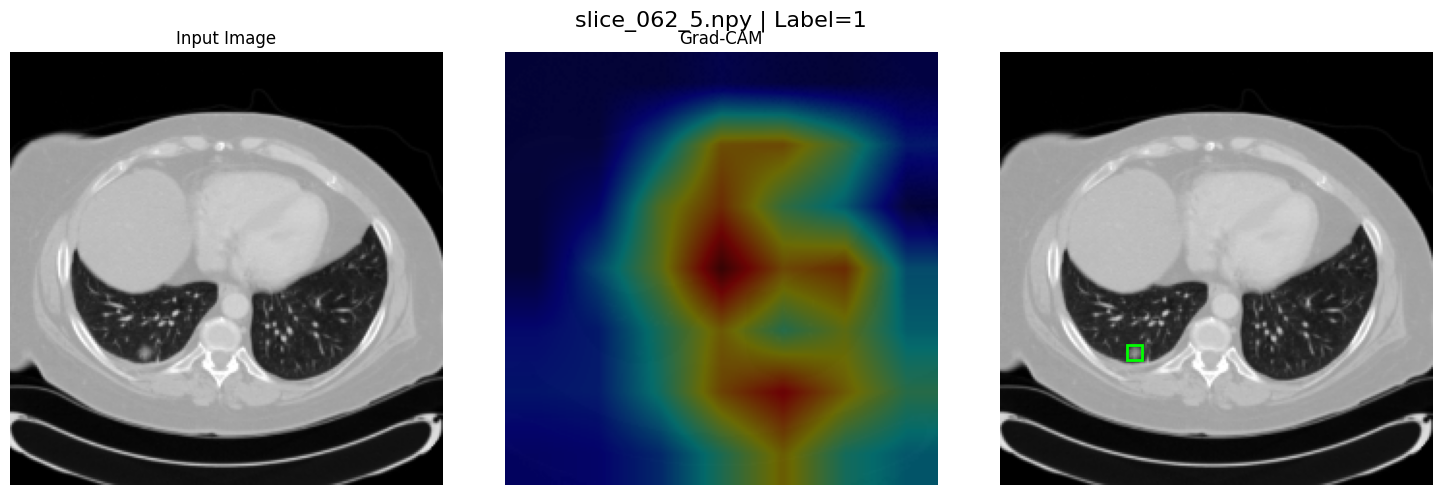

In [10]:
# ✅ Grad-CAM + Bounding Box Overlay (실제 CT 기반 최종 정리)

import os
import re
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import torch.nn.functional as F
import cv2
import pandas as pd
import sys
sys.path.append("/home/iujeong/lung_cancer")
from glob import glob
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from ResNet18_CBAM_MGA.core.config import CFG
from ResNet18_CBAM_MGA.core.dataset import CTDataset, load_bbox_dict, extract_label
from ResNet18_CBAM_MGA.core.model import ResNet18_CBAM
from ResNet18_CBAM_MGA.core.transforms import val_transform

# -------------------- 설정 --------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
slice_root = "/data1/lidc-idri/slices"
bbox_csv_path = "/home/iujeong/lung_cancer/csv/allbb_noPoly.csv"
save_path = "/home/iujeong/lung_cancer/logs/r18_cbam_mga_norotate_sc_mask_norotate_0520_2219.pth"
image_size = (224, 224)


# -------------------- 라벨 추출 --------------------
def extract_label_from_filename(fname):
    try:
        score = int(fname.split("_")[-1].replace(".npy", ""))
        return None if score == 3 else int(score >= 4)
    except:
        return None

# -------------------- Bounding Box 로드 --------------------
def load_bbox_dict(csv_path):
    df = pd.read_csv(csv_path)
    bbox_dict = {}
    for _, row in df.iterrows():
        pid = row['pid']                      # e.g. "LIDC-IDRI-0191"
        slice_str = row['slice']              # e.g. "slice_76"
        fname = f"{pid}_{slice_str}.npy"      # e.g. "LIDC-IDRI-0191_slice_76.npy"
        bbox = eval(row['bb'])                # 💡 bbox는 튜플
        bbox_dict.setdefault(fname, []).append(bbox)
    return bbox_dict

# -------------------- Grad-CAM --------------------
def generate_gradcam(model, image, target_layer, class_idx=None):
    activations, gradients = [], []
    def forward_hook(module, input, output): activations.append(output)
    def backward_hook(module, grad_input, grad_output): gradients.append(grad_output[0])
    hook_fwd = target_layer.register_forward_hook(forward_hook)
    hook_bwd = target_layer.register_backward_hook(backward_hook)
    if image.ndim == 3: image = image.unsqueeze(0)
    model.zero_grad()
    
    output = model(image.to(device))
    pred = output.argmax().item()
    print("💥 pred vs label:", pred, label.item())

    if class_idx is None: class_idx = output.argmax().item()
    output[0, class_idx].backward()
    act = activations[0].detach(); grad = gradients[0].detach()
    weights = grad.mean(dim=(2, 3), keepdim=True)
    cam = F.relu((weights * act).sum(dim=1)).squeeze()
    cam = F.interpolate(cam.unsqueeze(0).unsqueeze(0), size=image_size, mode='bilinear', align_corners=False).squeeze()
    cam = (cam - cam.min()) / (cam.max() + 1e-8)
    hook_fwd.remove(); hook_bwd.remove()
    return cam.cpu().numpy()

# -------------------- 데이터 로딩 --------------------
bbox_dict = load_bbox_dict(bbox_csv_path)
all_files = glob(os.path.join(slice_root, "LIDC-IDRI-*", "*.npy"))
file_label_pairs = [(f, extract_label_from_filename(f)) for f in all_files]
file_label_pairs = [(f, l) for f, l in file_label_pairs if l is not None]
files, labels = zip(*file_label_pairs)
_, temp_files, _, temp_labels = train_test_split(files, labels, test_size=0.3, random_state=42)
_, test_files, _, test_labels = train_test_split(temp_files, temp_labels, test_size=0.5, random_state=42)

# -------------------- 모델 로드 --------------------

dataset = CTDataset(test_files, test_labels, bbox_dict, transform=val_transform)
test_loader = DataLoader(dataset, batch_size=1)

model = ResNet18_CBAM().to(device)
model.load_state_dict(torch.load(save_path))  # 오류 안 나야 함!
model.eval()

# -------------------- 시각화 --------------------
idx = random.randint(0, len(dataset) - 1)
img_tensor, label, mask, fname, file_path = dataset[idx]
if isinstance(file_path, tuple): file_path = file_path[0]
if isinstance(fname, tuple): fname = fname[0]

print(f"💬 [INFO] CT file: {file_path}")
print(f"💬 [INFO] File name: {fname}")
print(f"💬 [INFO] Label: {label.item()}")

patient_id = os.path.basename(os.path.dirname(file_path))  # e.g. LIDC-IDRI-0191
slice_index = int(fname.split("_")[1])                     # e.g. 78

bbox_key = f"{patient_id}_slice_{slice_index}.npy"         # 👈 zero padding 제거된 key!
print(f"💬 [INFO] BBox key used: {bbox_key}")
# cam = generate_gradcam(model, img_tensor, model.layer3[1], class_idx=label.item())
# cam = generate_gradcam(model, img_tensor, model.layer4[1], class_idx=label.item())
# cam = generate_gradcam(model, img_tensor, model.layer3[0], class_idx=label.item())
cam = generate_gradcam(model, img_tensor, model.layer4[-1], class_idx=label.item())
img_np = img_tensor.squeeze().cpu().numpy()
img_uint8 = (img_np * 255).astype(np.uint8)

orig_h, orig_w = np.load(file_path).shape

heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

# 원본 이미지 밝기 조정해서 깔기
# 💡 CLAHE 적용 + 밝기/대비 조절 조합
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
img_clahe = clahe.apply(img_uint8)  # 히스토그램 균등화
input_rgb = cv2.cvtColor(img_clahe, cv2.COLOR_GRAY2RGB)
overlay_for_gradcam = cv2.addWeighted(input_rgb, 0.6, heatmap, 0.4, 0)
overlay_for_bbox = cv2.convertScaleAbs(input_rgb, alpha=2.0, beta=80)

# BBox 덧씌우기
for raw_bbox in bbox_dict.get(bbox_key, []):
    if len(raw_bbox) == 1 and isinstance(raw_bbox[0], list):
        raw_bbox = raw_bbox[0]
    try:
        (x1, x2), (y1, y2) = raw_bbox
    except Exception as e:
        print(f"[WARNING] bbox malformed: {raw_bbox} → {e}")
        continue
    x1 = int(x1 * image_size[1] / orig_w)
    x2 = int(x2 * image_size[1] / orig_w)
    y1 = int(y1 * image_size[0] / orig_h)
    y2 = int(y2 * image_size[0] / orig_h)
    cv2.rectangle(overlay_for_bbox, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=2)

# -------------------- 시각화 --------------------
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle(f"{fname} | Label={label.item()}", fontsize=16)

# 1. 원본
axes[0].imshow(img_np, cmap='gray')
axes[0].set_title("Input Image")
axes[0].axis('off')

# 2. Grad-CAM
axes[1].imshow(overlay_for_gradcam)
axes[1].set_title("Grad-CAM")
axes[1].axis('off')

# ✅ 3. CT 원본 + BBox 겹치기 (정답)
axes[2].imshow(img_np, cmap='gray', alpha=1.0)  # 배경을 CT 원본으로 깔고
axes[2].imshow(np.zeros_like(img_np), cmap='gray', alpha=0.0)  # matplotlib 렌더링 에러 방지용

# bbox_color = (0, 255, 0) if label.item() == 1 else (255, 0, 0)

# BBox 덧씌우기
import matplotlib.patches as patches

for raw_bbox in bbox_dict.get(bbox_key, []):
    if len(raw_bbox) == 1 and isinstance(raw_bbox[0], list):
        raw_bbox = raw_bbox[0]
    try:
        (x1, x2), (y1, y2) = raw_bbox
    except Exception as e:
        continue
    x1 = int(x1 * image_size[1] / orig_w)
    x2 = int(x2 * image_size[1] / orig_w)
    y1 = int(y1 * image_size[0] / orig_h)
    y2 = int(y2 * image_size[0] / orig_h)
    
    color = 'lime' if label.item() == 1 else 'red'
    rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                             linewidth=2, edgecolor=color, facecolor='none')
    axes[2].add_patch(rect)

axes[2].imshow(img_np, cmap='gray')  # CT 원본 선명하게
# OpenCV로 box 그린 이미지 → 이걸 그대로 시각화
# axes[2].imshow(overlay_for_bbox)
# axes[2].set_title(f"Overlay with BBox (Label={label.item()})")
axes[2].axis('off')
plt.tight_layout()
plt.show()

In [12]:
# ✅ Grad-CAM + Bounding Box Overlay (실제 CT 기반 최종 정리)

import os
import re
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import torch.nn.functional as F
import cv2
import pandas as pd
import sys
sys.path.append("/home/iujeong/lung_cancer")
from glob import glob
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from ResNet18_CBAM_MGA.core.config import CFG
from ResNet18_CBAM_MGA.core.dataset import CTDataset, load_bbox_dict, extract_label
from ResNet18_CBAM_MGA.core.model import ResNet18_CBAM
from ResNet18_CBAM_MGA.core.transforms import val_transform

# -------------------- 설정 --------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
slice_root = "/data1/lidc-idri/slices"
bbox_csv_path = "/home/iujeong/lung_cancer/csv/allbb_noPoly.csv"
save_path = "/home/iujeong/lung_cancer/logs/r18_cbam_mga_norotate_sc_mask_norotate_0520_2219.pth"
image_size = (224, 224)


# -------------------- 라벨 추출 --------------------
def extract_label_from_filename(fname):
    try:
        score = int(fname.split("_")[-1].replace(".npy", ""))
        return None if score == 3 else int(score >= 4)
    except:
        return None

# -------------------- Bounding Box 로드 --------------------
def load_bbox_dict(csv_path):
    df = pd.read_csv(csv_path)
    bbox_dict = {}
    for _, row in df.iterrows():
        pid = row['pid']                      # e.g. "LIDC-IDRI-0191"
        slice_str = row['slice']              # e.g. "slice_76"
        fname = f"{pid}_{slice_str}.npy"      # e.g. "LIDC-IDRI-0191_slice_76.npy"
        bbox = eval(row['bb'])                # 💡 bbox는 튜플
        bbox_dict.setdefault(fname, []).append(bbox)
    return bbox_dict

# -------------------- Grad-CAM --------------------
def generate_gradcam(model, image, target_layer, class_idx=None):
    activations, gradients = [], []
    def forward_hook(module, input, output): activations.append(output)
    def backward_hook(module, grad_input, grad_output): gradients.append(grad_output[0])
    hook_fwd = target_layer.register_forward_hook(forward_hook)
    hook_bwd = target_layer.register_backward_hook(backward_hook)
    if image.ndim == 3: image = image.unsqueeze(0)
    model.zero_grad()
    
    output = model(image.to(device))
    pred = output.argmax().item()
    print("💥 pred vs label:", pred, label.item())

    if class_idx is None: class_idx = output.argmax().item()
    output[0, class_idx].backward()
    act = activations[0].detach(); grad = gradients[0].detach()
    weights = grad.mean(dim=(2, 3), keepdim=True)
    cam = F.relu((weights * act).sum(dim=1)).squeeze()
    cam = F.interpolate(cam.unsqueeze(0).unsqueeze(0), size=image_size, mode='bilinear', align_corners=False).squeeze()
    cam = (cam - cam.min()) / (cam.max() + 1e-8)
    hook_fwd.remove(); hook_bwd.remove()
    return cam.cpu().numpy()

# -------------------- 데이터 로딩 --------------------
bbox_dict = load_bbox_dict(bbox_csv_path)
all_files = glob(os.path.join(slice_root, "LIDC-IDRI-*", "*.npy"))
file_label_pairs = [(f, extract_label_from_filename(f)) for f in all_files]
file_label_pairs = [(f, l) for f, l in file_label_pairs if l is not None]
files, labels = zip(*file_label_pairs)
_, temp_files, _, temp_labels = train_test_split(files, labels, test_size=0.3, random_state=42)
_, test_files, _, test_labels = train_test_split(temp_files, temp_labels, test_size=0.5, random_state=42)

# -------------------- 모델 로드 --------------------

dataset = CTDataset(test_files, test_labels, bbox_dict, transform=val_transform)
test_loader = DataLoader(dataset, batch_size=1)

model = ResNet18_CBAM().to(device)
model.load_state_dict(torch.load(save_path))  # 오류 안 나야 함!
model.eval()

# -------------------- 시각화 --------------------
idx = random.randint(0, len(dataset) - 1)
img_tensor, label, mask, fname, file_path = dataset[idx]
if isinstance(file_path, tuple): file_path = file_path[0]
if isinstance(fname, tuple): fname = fname[0]

print(f"💬 [INFO] CT file: {file_path}")
print(f"💬 [INFO] File name: {fname}")
print(f"💬 [INFO] Label: {label.item()}")

patient_id = os.path.basename(os.path.dirname(file_path))  # e.g. LIDC-IDRI-0191
slice_index = int(fname.split("_")[1])                     # e.g. 78

bbox_key = f"{patient_id}_slice_{slice_index}.npy"         # 👈 zero padding 제거된 key!
print(f"💬 [INFO] BBox key used: {bbox_key}")
# cam = generate_gradcam(model, img_tensor, model.layer3[1], class_idx=label.item())
# cam = generate_gradcam(model, img_tensor, model.layer4[1], class_idx=label.item())
# cam = generate_gradcam(model, img_tensor, model.layer3[0], class_idx=label.item())
cam = generate_gradcam(model, img_tensor, model.layer4[-1], class_idx=label.item())
img_np = img_tensor.squeeze().cpu().numpy()
img_uint8 = (img_np * 255).astype(np.uint8)

orig_h, orig_w = np.load(file_path).shape

heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

# 원본 이미지 밝기 조정해서 깔기
# 💡 CLAHE 적용 + 밝기/대비 조절 조합
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
img_clahe = clahe.apply(img_uint8)  # 히스토그램 균등화
input_rgb = cv2.cvtColor(img_clahe, cv2.COLOR_GRAY2RGB)
overlay_for_gradcam = cv2.addWeighted(input_rgb, 0.6, heatmap, 0.4, 0)
overlay_for_bbox = cv2.convertScaleAbs(input_rgb, alpha=2.0, beta=80)

# BBox 덧씌우기
for raw_bbox in bbox_dict.get(bbox_key, []):
    if len(raw_bbox) == 1 and isinstance(raw_bbox[0], list):
        raw_bbox = raw_bbox[0]
    try:
        (x1, x2), (y1, y2) = raw_bbox
    except Exception as e:
        print(f"[WARNING] bbox malformed: {raw_bbox} → {e}")
        continue
    x1 = int(x1 * image_size[1] / orig_w)
    x2 = int(x2 * image_size[1] / orig_w)
    y1 = int(y1 * image_size[0] / orig_h)
    y2 = int(y2 * image_size[0] / orig_h)
    cv2.rectangle(overlay_for_bbox, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=2)

# -------------------- 시각화 --------------------
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle(f"{fname} | Label={label.item()}", fontsize=16)

# 1. 원본
axes[0].imshow(img_np, cmap='gray')
axes[0].set_title("Input Image")
axes[0].axis('off')

# 2. Grad-CAM
axes[1].imshow(overlay_for_gradcam)
axes[1].set_title("Grad-CAM")
axes[1].axis('off')

# ✅ 3. CT 원본 + BBox 겹치기 (정답)
axes[2].imshow(img_np, cmap='gray', alpha=1.0)  # 배경을 CT 원본으로 깔고
axes[2].imshow(np.zeros_like(img_np), cmap='gray', alpha=0.0)  # matplotlib 렌더링 에러 방지용

# bbox_color = (0, 255, 0) if label.item() == 1 else (255, 0, 0)

# BBox 덧씌우기
import matplotlib.patches as patches

for raw_bbox in bbox_dict.get(bbox_key, []):
    if len(raw_bbox) == 1 and isinstance(raw_bbox[0], list):
        raw_bbox = raw_bbox[0]
    try:
        (x1, x2), (y1, y2) = raw_bbox
    except Exception as e:
        continue
    x1 = int(x1 * image_size[1] / orig_w)
    x2 = int(x2 * image_size[1] / orig_w)
    y1 = int(y1 * image_size[0] / orig_h)
    y2 = int(y2 * image_size[0] / orig_h)
    
    color = 'lime' if label.item() == 1 else 'red'
    rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                             linewidth=2, edgecolor=color, facecolor='none')
    axes[2].add_patch(rect)

axes[2].imshow(img_np, cmap='gray')  # CT 원본 선명하게
# OpenCV로 box 그린 이미지 → 이걸 그대로 시각화
# axes[2].imshow(overlay_for_bbox)
# axes[2].set_title(f"Overlay with BBox (Label={label.item()})")
axes[2].axis('off')
plt.tight_layout()
plt.show()

💬 [INFO] CT file: /data1/lidc-idri/slices/LIDC-IDRI-0402/slice_105_4.npy
💬 [INFO] File name: slice_105_4.npy
💬 [INFO] Label: 1
💬 [INFO] BBox key used: LIDC-IDRI-0402_slice_105.npy
💥 pred vs label: 1 1


/opt/anaconda3/envs/lungcancer/lib/python3.12/site-packages/torch/nn/modules/module.py:1842: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


In [2]:
# ✅ Grad-CAM + Bounding Box Overlay (실제 CT 기반 최종 정리)

import os
import re
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import torch.nn.functional as F
import cv2
import pandas as pd
import sys
sys.path.append("/home/iujeong/lung_cancer")
from glob import glob
from sklearn.model_selection import train_test_split
from ResNet18_CBAM_MGA.core.config import CFG
from ResNet18_CBAM_MGA.core.dataset import CTDataset, load_bbox_dict, extract_label
from ResNet18_CBAM_MGA.core.model import ResNet18_CBAM
from ResNet18_CBAM_MGA.core.transforms import val_transform

# -------------------- 설정 --------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
slice_root = "/data1/lidc-idri/slices"
bbox_csv_path = "/home/iujeong/lung_cancer/csv/allbb_noPoly.csv"
save_path = "/home/iujeong/lung_cancer/logs/r18_cbam_mga_norotate_sc_mask_norotate_0520_2219.pth"
image_size = (224, 224)


# -------------------- 라벨 추출 --------------------
def extract_label_from_filename(fname):
    try:
        score = int(fname.split("_")[-1].replace(".npy", ""))
        return None if score == 3 else int(score >= 4)
    except:
        return None

# -------------------- Bounding Box 로드 --------------------
def load_bbox_dict(csv_path):
    df = pd.read_csv(csv_path)
    bbox_dict = {}
    for _, row in df.iterrows():
        pid = row['pid']                      # e.g. "LIDC-IDRI-0191"
        slice_str = row['slice']              # e.g. "slice_76"
        fname = f"{pid}_{slice_str}.npy"      # e.g. "LIDC-IDRI-0191_slice_76.npy"
        bbox = eval(row['bb'])                # 💡 bbox는 튜플
        bbox_dict.setdefault(fname, []).append(bbox)
    return bbox_dict

# -------------------- Grad-CAM --------------------
def generate_gradcam(model, image, target_layer, class_idx=None):
    activations, gradients = [], []
    def forward_hook(module, input, output): activations.append(output)
    def backward_hook(module, grad_input, grad_output): gradients.append(grad_output[0])
    hook_fwd = target_layer.register_forward_hook(forward_hook)
    hook_bwd = target_layer.register_backward_hook(backward_hook)
    if image.ndim == 3: image = image.unsqueeze(0)
    model.zero_grad()
    
    output = model(img_tensor.to(device))
    pred = output.argmax().item()
    print("💥 pred vs label:", pred, label.item())

    if class_idx is None: class_idx = output.argmax().item()
    output[0, class_idx].backward()
    act = activations[0].detach(); grad = gradients[0].detach()
    weights = grad.mean(dim=(2, 3), keepdim=True)
    cam = F.relu((weights * act).sum(dim=1)).squeeze()
    cam = F.interpolate(cam.unsqueeze(0).unsqueeze(0), size=image_size, mode='bilinear', align_corners=False).squeeze()
    cam = (cam - cam.min()) / (cam.max() + 1e-8)
    hook_fwd.remove(); hook_bwd.remove()
    return cam.cpu().numpy()

# -------------------- 데이터 로딩 --------------------
bbox_dict = load_bbox_dict(bbox_csv_path)
all_files = glob(os.path.join(slice_root, "LIDC-IDRI-*", "*.npy"))
file_label_pairs = [(f, extract_label_from_filename(f)) for f in all_files]
file_label_pairs = [(f, l) for f, l in file_label_pairs if l is not None]
files, labels = zip(*file_label_pairs)
_, temp_files, _, temp_labels = train_test_split(files, labels, test_size=0.3, random_state=42)
_, test_files, _, test_labels = train_test_split(temp_files, temp_labels, test_size=0.5, random_state=42)

# -------------------- 모델 로드 --------------------
from torch.utils.data import DataLoader

test_loader = DataLoader(
    CTDataset(test_files, test_labels, bbox_dict, transform=val_transform),
    batch_size=1
)
model = ResNet18_CBAM().to(device)
model.load_state_dict(torch.load(save_path))  # 오류 안 나야 함!
model.eval()

# -------------------- 시각화 --------------------
img_tensor, label, mask, fname, file_path = next(iter(test_loader))
if isinstance(file_path, tuple): file_path = file_path[0]
if isinstance(fname, tuple): fname = fname[0]
patient_id = os.path.basename(os.path.dirname(file_path))  # e.g. LIDC-IDRI-0191
slice_index = int(fname.split("_")[1])                     # e.g. 78
bbox_key = f"{patient_id}_slice_{slice_index}.npy"         # 👈 zero padding 제거된 key!
# cam = generate_gradcam(model, img_tensor, model.layer3[1], class_idx=label.item())
cam = generate_gradcam(model, img_tensor, model.layer4[1], class_idx=label.item())
img_np = img_tensor.squeeze().cpu().numpy()
img_uint8 = (img_np * 255).astype(np.uint8)

orig_h, orig_w = np.load(file_path).shape

heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

# 1. 입력 이미지 대비 조정 (CLAHE 적용)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
img_clahe = clahe.apply(img_uint8)  # 대비 향상된 흑백 이미지
input_rgb = cv2.cvtColor(img_clahe, cv2.COLOR_GRAY2RGB)

overlay_for_gradcam = cv2.addWeighted(input_rgb, 0.6, heatmap, 0.4, 0)
overlay_for_bbox = input_rgb.copy()

# 🔲 BBox 덧씌우기
for raw_bbox in bbox_dict.get(bbox_key, []):
    if len(raw_bbox) == 1 and isinstance(raw_bbox[0], list):
        raw_bbox = raw_bbox[0]
    try:
        (x1, x2), (y1, y2) = raw_bbox
    except Exception as e:
        print(f"[WARNING] bbox malformed: {raw_bbox} → {e}")
        continue

    x1 = int(x1 * image_size[1] / orig_w)
    x2 = int(x2 * image_size[1] / orig_w)
    y1 = int(y1 * image_size[0] / orig_h)
    y2 = int(y2 * image_size[0] / orig_h)

    cv2.rectangle(overlay_for_bbox, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=2)

# -------------------- 시각화 --------------------
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(img_np, cmap='gray')
axes[0].set_title("Input Image")
axes[0].axis('off')

axes[1].imshow(overlay_for_gradcam)
axes[1].set_title("Grad-CAM")
axes[1].axis('off')

axes[2].imshow(overlay_for_bbox)
axes[2].set_title(f"Overlay with BBox (Label={label.item()})")
axes[2].axis('off')

plt.tight_layout()
plt.show()

💥 pred vs label: 1 1


/opt/anaconda3/envs/lungcancer/lib/python3.12/site-packages/torch/nn/modules/module.py:1842: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


/opt/anaconda3/envs/lungcancer/lib/python3.12/site-packages/torch/nn/modules/module.py:1842: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


💥 pred vs label: 1 1
[DEBUG] fname: slice_078_5.npy
[DEBUG] BBox key used: LIDC-IDRI-0191_slice_78.npy
[DEBUG] BBoxes: [[[[119, 131], [244, 254]]]]
[DEBUG] orig_h, orig_w: 460, 460


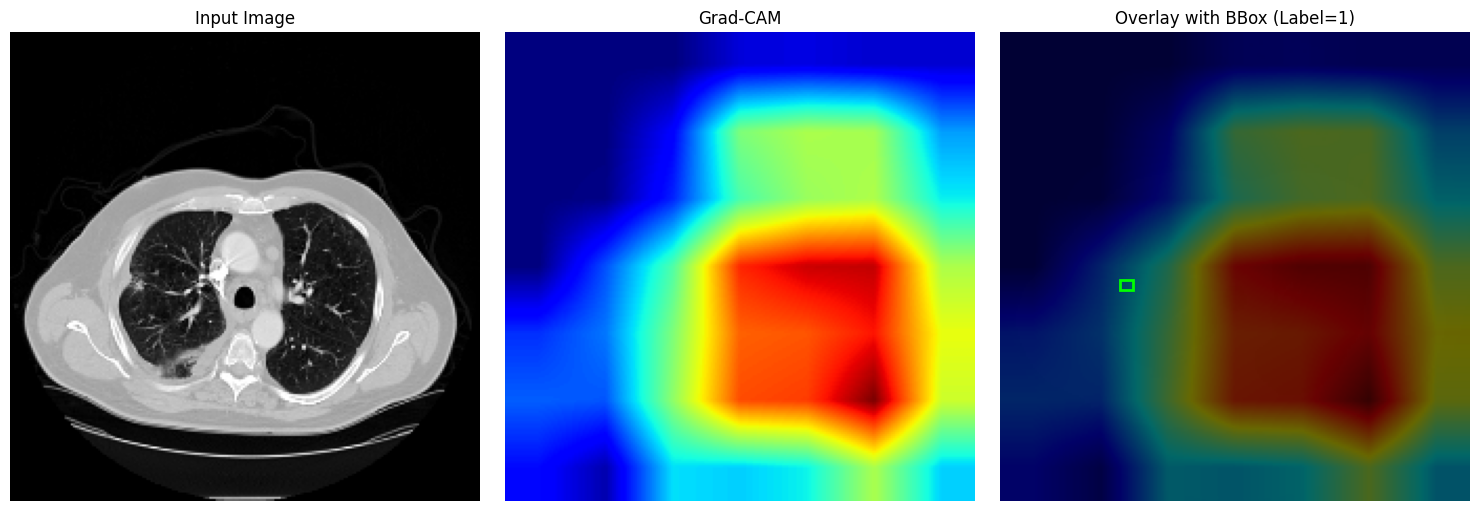

In [16]:
# ✅ Grad-CAM + Bounding Box Overlay (실제 CT 기반 최종 정리)

import os
import re
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import cv2
import pandas as pd
import sys
sys.path.append("/home/iujeong/lung_cancer")
from glob import glob
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
from ResNet18_CBAM_MGA.core.config import CFG
from ResNet18_CBAM_MGA.core.dataset import CTDataset, load_bbox_dict, extract_label
from ResNet18_CBAM_MGA.core.model import ResNet18_CBAM
from ResNet18_CBAM_MGA.core.transforms import val_transform

# -------------------- 설정 --------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
slice_root = "/data1/lidc-idri/slices"
bbox_csv_path = "/home/iujeong/lung_cancer/csv/allbb_noPoly.csv"
save_path = "/home/iujeong/lung_cancer/logs/r18_cbam_mga_norotate_sc_mask_norotate_0520_2219.pth"
image_size = (224, 224)


# -------------------- 라벨 추출 --------------------
def extract_label_from_filename(fname):
    try:
        score = int(fname.split("_")[-1].replace(".npy", ""))
        return None if score == 3 else int(score >= 4)
    except:
        return None

# -------------------- Bounding Box 로드 --------------------
def load_bbox_dict(csv_path):
    df = pd.read_csv(csv_path)
    bbox_dict = {}
    for _, row in df.iterrows():
        pid = row['pid']                      # e.g. "LIDC-IDRI-0191"
        slice_str = row['slice']              # e.g. "slice_76"
        fname = f"{pid}_{slice_str}.npy"      # e.g. "LIDC-IDRI-0191_slice_76.npy"
        bbox = eval(row['bb'])                # 💡 bbox는 튜플
        bbox_dict.setdefault(fname, []).append(bbox)
    return bbox_dict

# -------------------- Grad-CAM --------------------
def generate_gradcam(model, image, target_layer, class_idx=None):
    activations, gradients = [], []
    def forward_hook(module, input, output): activations.append(output)
    def backward_hook(module, grad_input, grad_output): gradients.append(grad_output[0])
    hook_fwd = target_layer.register_forward_hook(forward_hook)
    hook_bwd = target_layer.register_backward_hook(backward_hook)
    if image.ndim == 3: image = image.unsqueeze(0)
    model.zero_grad()
    
    output = model(img_tensor.to(device))
    pred = output.argmax().item()
    print("💥 pred vs label:", pred, label.item())

    if class_idx is None: class_idx = output.argmax().item()
    output[0, class_idx].backward()
    act = activations[0].detach(); grad = gradients[0].detach()
    weights = grad.mean(dim=(2, 3), keepdim=True)
    cam = F.relu((weights * act).sum(dim=1)).squeeze()
    cam = F.interpolate(cam.unsqueeze(0).unsqueeze(0), size=image_size, mode='bilinear', align_corners=False).squeeze()
    cam = (cam - cam.min()) / (cam.max() + 1e-8)
    hook_fwd.remove(); hook_bwd.remove()
    return cam.cpu().numpy()

# -------------------- 데이터 로딩 --------------------
bbox_dict = load_bbox_dict(bbox_csv_path)
all_files = glob(os.path.join(slice_root, "LIDC-IDRI-*", "*.npy"))
file_label_pairs = [(f, extract_label_from_filename(f)) for f in all_files]
file_label_pairs = [(f, l) for f, l in file_label_pairs if l is not None]
files, labels = zip(*file_label_pairs)
_, temp_files, _, temp_labels = train_test_split(files, labels, test_size=0.3, random_state=42)
_, test_files, _, test_labels = train_test_split(temp_files, temp_labels, test_size=0.5, random_state=42)

# -------------------- 모델 로드 --------------------
from torch.utils.data import DataLoader

test_loader = DataLoader(
    CTDataset(test_files, test_labels, bbox_dict, transform=val_transform),
    batch_size=1
)
model = ResNet18_CBAM().to(device)
model.load_state_dict(torch.load(save_path))  # 오류 안 나야 함!
model.eval()

# -------------------- 시각화 --------------------
import matplotlib.patches as patches

img_tensor, label, mask, fname, file_path = next(iter(test_loader))
if isinstance(file_path, tuple): file_path = file_path[0]
if isinstance(fname, tuple): fname = fname[0]
patient_id = os.path.basename(os.path.dirname(file_path))  # e.g. LIDC-IDRI-0191
slice_index = int(fname.split("_")[1])                     # e.g. 78
bbox_key = f"{patient_id}_slice_{slice_index}.npy"         # 👈 zero padding 제거된 key!
# cam = generate_gradcam(model, img_tensor, model.layer3[1], class_idx=label.item())
cam = generate_gradcam(model, img_tensor, model.layer4[1], class_idx=label.item())
img_np = img_tensor.squeeze().cpu().numpy()
img_uint8 = (img_np * 255).astype(np.uint8)
input_rgb = cv2.cvtColor(img_uint8, cv2.COLOR_GRAY2RGB)

heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

overlay = cv2.addWeighted(input_rgb, 0.6, heatmap, 0.4, 0)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(img_np, cmap='gray'); axes[0].axis('off'); axes[0].set_title("Input Image")
axes[1].imshow(cam, cmap='jet'); axes[1].axis('off'); axes[1].set_title("Grad-CAM")
axes[2].imshow(overlay); axes[2].axis('off'); axes[2].set_title(f"Overlay with BBox (Label={label.item()})")

# 🔍 디버깅용 로그
print(f"[DEBUG] fname: {fname}")
print(f"[DEBUG] BBox key used: {bbox_key}")
print(f"[DEBUG] BBoxes: {bbox_dict.get(bbox_key)}")
print(f"[DEBUG] orig_h, orig_w: {orig_h}, {orig_w}")

# 🔲 BBox 실제 시각화
for raw_bbox in bbox_dict.get(bbox_key, []):
    # 리스트가 1-depth 더 깊을 경우 flatten
    if len(raw_bbox) == 1 and isinstance(raw_bbox[0], list):
        raw_bbox = raw_bbox[0]

    try:
        (x1, x2), (y1, y2) = raw_bbox  # ✅ 여기 고쳐야 함
    except Exception as e:
        print(f"[WARNING] bbox malformed: {raw_bbox} → {e}")
        continue

    # 이후 동일하게 정규화
    x1 = int(x1 * image_size[1] / orig_w)
    x2 = int(x2 * image_size[1] / orig_w)
    y1 = int(y1 * image_size[0] / orig_h)
    y2 = int(y2 * image_size[0] / orig_h)

    rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                             linewidth=2, edgecolor='lime', facecolor='none')
    axes[2].add_patch(rect)

plt.tight_layout(); plt.show()

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import cv2
from glob import glob
from sklearn.model_selection import train_test_split

import sys
sys.path.append("/home/iujeong/lung_cancer")  # 루트 경로를 명시

from ResNet18_CBAM_MGA.core.config import CFG
from ResNet18_CBAM_MGA.core.model import ResNet18_CBAM
from ResNet18_CBAM_MGA.core.dataset import CTDataset, extract_label, load_bbox_dict

from ResNet18_CBAM_MGA.core.transforms import val_transform

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# 1. Grad-CAM Hook 등록
# -------------------- Grad-CAM Hook --------------------
features = None
grads = None

def forward_hook(module, input, output):
    global features
    features = output

def backward_hook(module, grad_input, grad_output):
    global grads
    grads = grad_output[0]

# -------------------- Grad-CAM 계산 함수 --------------------
def compute_gradcam(image_tensor, label, model):
    global features, grads
    model.zero_grad()

    image_tensor = image_tensor.unsqueeze(0)  # [1, C, H, W]
    label = label.to(CFG.device)  # 💥 이거 추가!

    output = model(image_tensor)
    pred_class = output.argmax(dim=1).item()

    # 정답 라벨 기준 loss
    loss = F.cross_entropy(output, label.unsqueeze(0))  # OK
    loss.backward()

    pooled_grads = torch.mean(grads, dim=[0, 2, 3])
    cam = torch.zeros(features.shape[2:], dtype=torch.float32).to(CFG.device)
    for i in range(features.shape[1]):
        cam += pooled_grads[i] * features[0, i]

    cam = F.relu(cam)
    cam -= cam.min()
    if cam.max() != 0:
        cam /= cam.max()
    else:
        cam = torch.zeros_like(cam)

    cam = F.interpolate(cam.unsqueeze(0).unsqueeze(0), size=CFG.input_size, mode="bilinear", align_corners=False)
    return cam.squeeze().detach().cpu().numpy(), pred_class

# -------------------- 시각화 함수 --------------------
def visualize_gradcam(model, dataset, bbox_dict, num_samples=10):
    model.eval()
    indices = random.sample(range(len(dataset)), num_samples)
    fig, axs = plt.subplots(num_samples, 3, figsize=(12, 4 * num_samples))

    for i, idx in enumerate(indices):
        img, label, mask = dataset[idx]
        fname = os.path.basename(dataset.paths[idx])
        img_input = img.to(device)

        cam, pred = compute_gradcam(img_input, label, model)
        original = img.squeeze().cpu().numpy()

        # Grad-CAM Overlay
        heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
        heatmap = np.float32(heatmap) / 255

        # 원본 크기 조정
        original_resized = cv2.resize(original, (cam.shape[1], cam.shape[0]))

        # 💡 채널 차원 맞추기 (gray → RGB)
        if len(original_resized.shape) == 2:
            original_resized = np.stack([original_resized]*3, axis=-1)

        # ✅ 알파 블렌딩 비율 조절 (0.3 → 원본, 0.7 → heatmap)
        overlay = heatmap * 0.7 + original_resized * 0.3
        overlay = np.clip(overlay, 0, 1)

        # BBox
        bbox_img = np.copy(original)
        if fname in bbox_dict:
            for bbox in bbox_dict[fname]:
                x1, y1, x2, y2 = bbox
                cv2.rectangle(bbox_img, (x1, y1), (x2, y2), (1,), 1)

        axs[i, 0].imshow(original, cmap='gray')
        axs[i, 0].set_title(f"Original (Label={label})")

        axs[i, 1].imshow(overlay, cmap='gray')
        axs[i, 1].set_title(f"Grad-CAM + Mask (Pred={pred})")

        axs[i, 2].imshow(bbox_img, cmap='gray')
        axs[i, 2].set_title("BBox")

        for j in range(3):
            axs[i, j].axis('off')

    plt.tight_layout()
    plt.show()

# -------------------- 실행 --------------------
def run_gradcam():
    # 모델 로드
    model = ResNet18_CBAM(num_classes=CFG.num_classes).to(device)
    model_path = "/home/iujeong/lung_cancer/logs/r18_cbam_mga_sc_weight.pth"
    model.load_state_dict(torch.load(model_path, map_location=CFG.device))
    print(f"✅ 모델 로드 완료: {model_path}")

    # Hook 등록
    # 예시
    model.layer4[1].conv2.register_forward_hook(forward_hook)
    model.layer4[1].conv2.register_full_backward_hook(backward_hook)
    # model.layer3[1].cbam.sa.register_forward_hook(forward_hook)
    # model.layer3[1].cbam.sa.register_full_backward_hook(backward_hook)

    # 데이터 로딩
    all_files = glob(os.path.join(CFG.data_root, "**/*.npy"), recursive=True)
    file_label_pairs = [(f, extract_label(os.path.basename(f))) for f in all_files if extract_label(os.path.basename(f)) is not None]
    files, labels = zip(*file_label_pairs)
    _, test_files, _, test_labels = train_test_split(files, labels, test_size=0.2, random_state=42)

    bbox_dict = load_bbox_dict(CFG.bbox_csv)
    test_dataset = CTDataset(test_files, test_labels, transform=val_transform)

    # 시각화
    visualize_gradcam(model, test_dataset, bbox_dict, num_samples=10)

if __name__ == "__main__":
    run_gradcam()





cuda
✅ 모델 로드 완료: /home/iujeong/lung_cancer/logs/r18_cbam_mga_sc_weight.pth
